# IMPORT LIBRARY

In [1]:
# library untuk pengolahan data
import pandas as pd
import numpy as np

# library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk meachine learning model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## LOAD DATASET

In [2]:
# Membaca data dari file CSV menjadi DataFrame
customer_df = pd.read_csv('Customer.csv', sep=';')
store_df = pd.read_csv('Store.csv', sep=';')
product_df = pd.read_csv('Product.csv', sep=';')
transaction_df = pd.read_csv('Transaction.csv', sep=';')

In [3]:
# Menggabungkan data transaksi dengan data customer berdasarkan CustomerID
merged_df = pd.merge(transaction_df, customer_df, on='CustomerID', how='inner')

# Menggabungkan data hasil penggabungan di atas dengan data store berdasarkan StoreID
merged_df = pd.merge(merged_df, store_df, on='StoreID', how='inner')

# Menggabungkan data hasil penggabungan di atas dengan data product berdasarkan ProductID
merged_df = pd.merge(merged_df, product_df, on='ProductID', how='inner')

In [4]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TransactionID   5020 non-null   object
 1   CustomerID      5020 non-null   int64 
 2   Date            5020 non-null   object
 3   ProductID       5020 non-null   object
 4   Price_x         5020 non-null   int64 
 5   Qty             5020 non-null   int64 
 6   TotalAmount     5020 non-null   int64 
 7   StoreID         5020 non-null   int64 
 8   Age             5020 non-null   int64 
 9   Gender          5020 non-null   int64 
 10  Marital Status  4976 non-null   object
 11  Income          5020 non-null   object
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
 18  Price_y 

# DATA PREPARATION

## HANDLING MISSING VALUE

In [5]:
merged_df.isnull().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
Price_y            0
dtype: int64

In [6]:
merged_df.dropna(inplace=True)
merged_df.isnull().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
Product Name      0
Price_y           0
dtype: int64

## DUPLICATE DATA

In [7]:
merged_df.duplicated().sum()

0

## DATA TRANSFORMATION


In [8]:
merged_df.dtypes

TransactionID     object
CustomerID         int64
Date              object
ProductID         object
Price_x            int64
Qty                int64
TotalAmount        int64
StoreID            int64
Age                int64
Gender             int64
Marital Status    object
Income            object
StoreName         object
GroupStore        object
Type              object
Latitude          object
Longitude         object
Product Name      object
Price_y            int64
dtype: object

In [18]:
# Mengubah kolom "Date" menjadi tipe data datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

# Cek tipe data setelah perubahan
merged_df.dtypes

TransactionID             object
CustomerID                 int64
Date              datetime64[ns]
ProductID                 object
Price_x                    int64
Qty                        int64
TotalAmount                int64
StoreID                    int64
Age                        int64
Gender                     int64
Marital Status            object
Income                    object
StoreName                 object
GroupStore                object
Type                      object
Latitude                  object
Longitude                 object
Product Name              object
Price_y                    int64
dtype: object

# Regression Analysis

In [10]:
# Agregasi data ke tingkat harian dan menghitung total "Qty" per hari
daily_sales = merged_df.groupby('Date')['Qty'].sum().reset_index()
daily_sales.set_index(daily_sales['Date'])
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Qty     365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [20]:
# memisah data bulan terakhir untuk diuji
cut_data = int(len(daily_sales) * 0.9)
df_train = daily_sales[:cut_data]
df_test = daily_sales[cut_data:]

df_train.shape, df_test.shape

((328, 2), (37, 2))

<Axes: xlabel='Date', ylabel='Qty'>

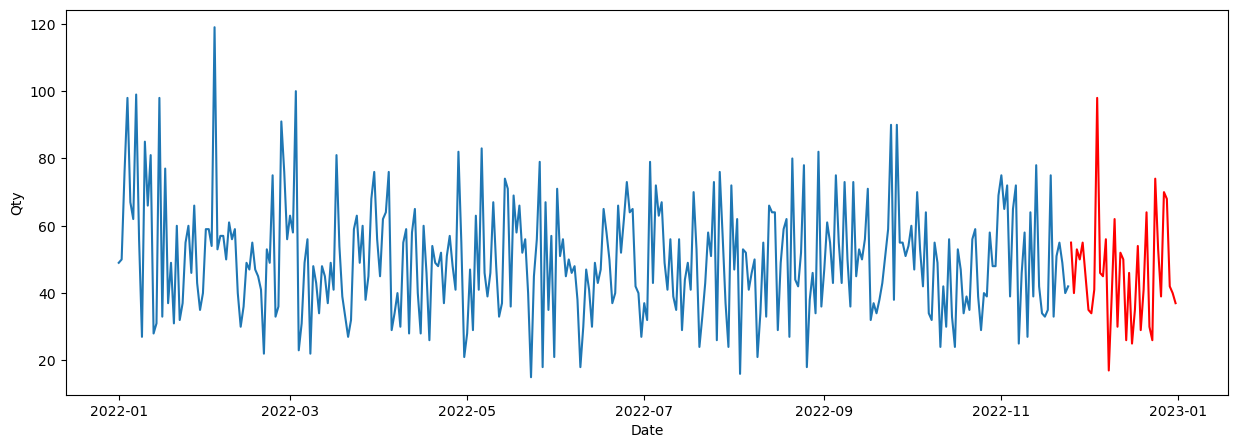

In [12]:
plt.figure(figsize=(15,5))
sns.lineplot(data= df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data= df_test, x=df_test['Date'], y=df_test['Qty'], color='red')

In [13]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    328 non-null    datetime64[ns]
 1   Qty     328 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB


## Tes Stasioneritas

In [14]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    p_value = result[1]
    print("P-Value:", p_value)
    if p_value <= 0.05:
        print("Data stasioner.")
    else:
        print("Data tidak stasioner.")

df_train = df_train['Qty'].values
# Uji stasioneritas data differenced
test_stationarity(df_train)

P-Value: 2.627739874174284e-30
Data stasioner.


## Tes ARIMA

### Menentukan Parameter ARIMA

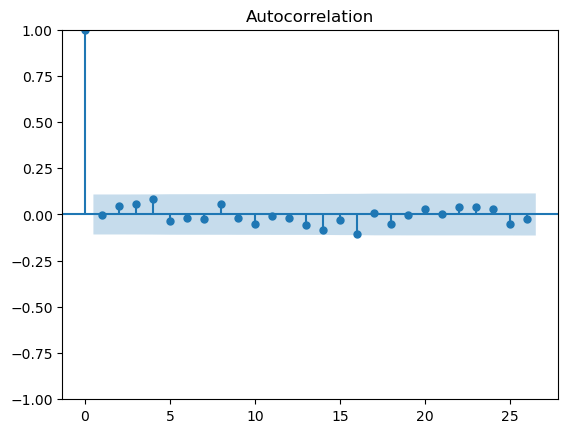

In [15]:
# Plot ACF dan PACF untuk menentukan parameter ARIMA

plot_acf(df_train)
plt.show()

#p=1 berdasarkan lag di mana ACF tiba-tiba menurun menjadi 0 atau mendekati 0.

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


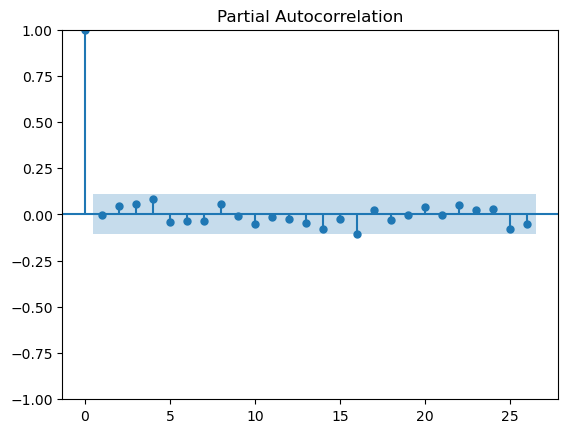

In [16]:
plot_pacf(df_train)
plt.show()

#q=1 berdasarkan lag di mana PACF tiba-tiba menurun menjadi 0 atau mendekati 0.

### Uji ARIMA

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2797.248, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3534.863, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2997.345, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3319.012, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2796.376, Time=0.93 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3202.675, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2794.416, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2796.374, Time=0.47 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2906.047, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2788.078, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2786.080, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2784.081, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2786.080, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 3.566 seconds
Hasil Prediksi:
      Prediksi
328  50.070122
329  50.070122
330 

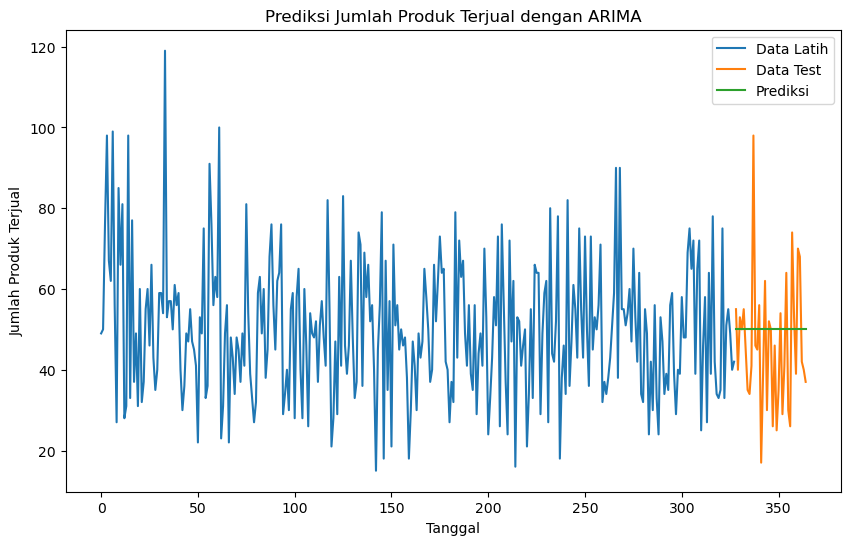

In [21]:
from pmdarima.arima import auto_arima
# Menggunakan auto_arima untuk menentukan parameter p, d, dan q yang tepat
model = auto_arima(df_train['Qty'], seasonal=False, trace=True)

# Melatih model ARIMA dengan parameter terbaik
model.fit(df_train['Qty'])

# Prediksi pada data uji
forecast_steps = len(df_test)
forecast = model.predict(n_periods=forecast_steps)

# Membuat DataFrame dari hasil prediksi ARIMA
forecast_df = pd.DataFrame(forecast, index=df_test.index, columns=['Prediksi'])

# Menampilkan hasil prediksi
print("Hasil Prediksi:")
print(forecast_df)

# Visualisasi hasil prediksi
plt.figure(figsize=(10, 6))
plt.plot(df_train['Qty'], label='Data Latih')
plt.plot(df_test['Qty'], label='Data Test')
plt.plot(forecast_df, label='Prediksi')
plt.legend()
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Produk Terjual')
plt.title('Prediksi Jumlah Produk Terjual dengan ARIMA')
plt.show()

# Clustering Analysis

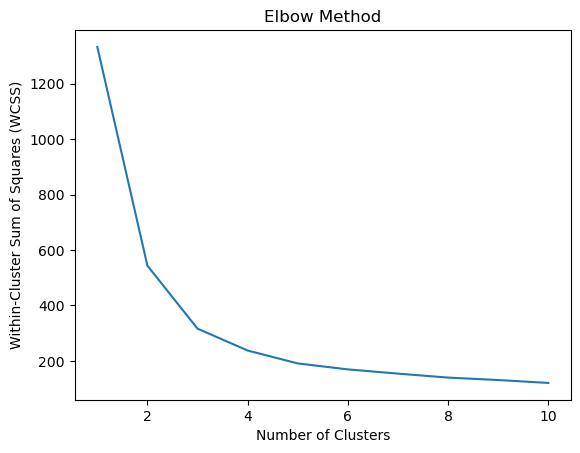

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')

# Menghapus kolom CustomerID
data_for_clustering = merged_df.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}).reset_index(drop=True)

# Standarisasi data untuk clustering (jika diperlukan)
scaler = StandardScaler()
data_for_clustering_scaled = scaler.fit_transform(data_for_clustering)

# Menentukan jumlah kluster dengan Elbow Method
wcss = []  # Within-Cluster Sum of Squares
for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_for_clustering_scaled)
    wcss.append(kmeans.inertia_)

# Visualisasi Elbow Method
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method')
plt.show()
warnings.filterwarnings('default')


In [40]:

warnings.filterwarnings('ignore')
# Menggunakan Metode Clustering KMeans dengan jumlah kluster yang sesuai
num_clusters = 4  # sesuai dari hasil elbow method
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(data_for_clustering_scaled)

# Dapatkan label kluster untuk setiap data
data_for_clustering['ClusterLabel'] = kmeans.labels_

# Tampilkan hasil kluster
print(data_for_clustering)
warnings.filterwarnings('default')

     TransactionID  Qty  TotalAmount  ClusterLabel
0               17   60       623300             3
1               13   57       392300             1
2               15   56       446200             1
3               10   46       302500             2
4                7   27       268600             0
..             ...  ...          ...           ...
439             13   37       269400             2
440             18   62       577700             3
441             18   68       587200             3
442             11   42       423300             2
443             13   42       439300             1

[444 rows x 4 columns]


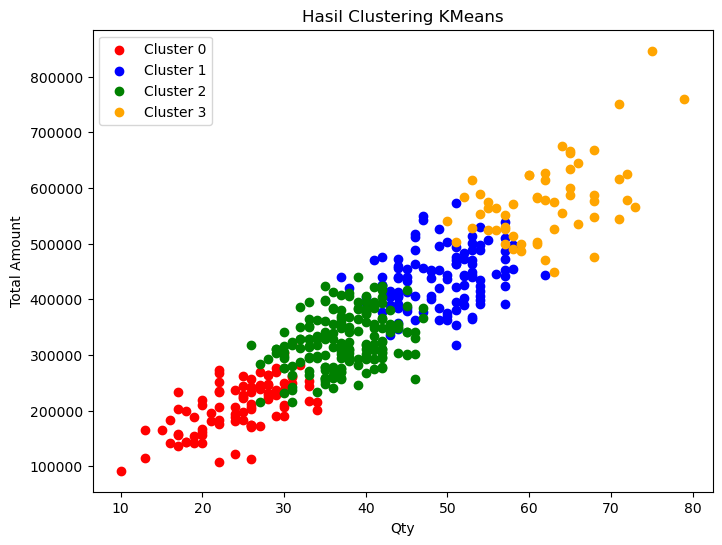

In [39]:
# Visualisasi hasil clustering dengan scatter plot
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']  # Ganti dengan warna sesuai dengan jumlah kluster
for cluster_label in range(num_clusters):
    cluster_data = data_for_clustering[data_for_clustering['ClusterLabel'] == cluster_label]
    plt.scatter(cluster_data['Qty'], cluster_data['TotalAmount'], color=colors[cluster_label], label=f'Cluster {cluster_label}')

plt.xlabel('Qty')
plt.ylabel('Total Amount')
plt.title('Hasil Clustering KMeans')
plt.legend()
plt.show()